# **Exploratory Data Analysis (EDA)**



# 1. Import Necessary Libraries and datasets

 ##  a. Load libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import fuzzywuzzy
from fuzzywuzzy import process
import plotly.express as px
import warnings
%matplotlib inline

# Created python modules
from mlp import missing_module as mm
from mlp import visualization_module as vm
from mlp import feature_engineer_module as fm
from mlp import algorithm_module as am

warnings.filterwarnings('ignore')
print("Libraries imported.")

Libraries imported.


## b. Load dataset

In [2]:
url = "https://aisgaiap.blob.core.windows.net/aiap6-assessment-data/scooter_rental_data.csv"
data = pd.read_csv(url)

#data = pd.read_csv("../input/scooter_rental_data.csv")
print("Dataset loaded.")
data.head()

Dataset loaded.


date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  
0               81.0        0.0    3           21               164  
1               80.0        0.0   35           54               417  
2               80.0        0.0   38           35               356  
3               75.0        0.0   35           19               129  
4               75.0        0.0   11           -2                10

## c. Overview of dataset report

In [3]:
profile = ProfileReport(data)
profile

### Small feature engineering before seperating the dataset
> * Date is not compared in the correlation since its in data-time format.
> * Extract month feature from datatime to observe its correlation
> * Year not extracted due to limited observations in dataset (2011 and 2012 only)
> * Day is an insignificant correlation (extremely low correlation against target variables, 0.003)
> * Drop all the duplicate rows since they are redundant information

In [14]:
# Drop duplicates from dataset
fm.duplicate_drop(data)

(17958, 10)
(17379, 10)
Number of duplicates dropped: 
Rows: 579
Columns: 0


In [6]:
# Add month feature before seperating dataset
data['month'] = pd.to_datetime(data['date']).dt.month
# Month feature added
data.head()

date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  
0               81.0        0.0    3           21               164      1  
1               80.0        0.0   35           54               417      1  
2               80.0        0.0   38           35               356      1  
3               75.0        0.0   35           19               129      1  
4               75.0        0.0   11           -2                10      1

## d. Seperate dataset into train and test sets

In [8]:
# Seperate data into train and test set (80/20)
train = data.iloc[:-3480, :]     
test = data.iloc[-3480:, :]

In [9]:
# Describe full data, train and test sets
print("Original dataset has {} rows and {} columns.".format(data.shape[0], data.shape[1]))
print("\nSeperating dataset into train and test set...\n")
print("Train set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("Test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

Original dataset has 17379 rows and 11 columns.

Seperating dataset into train and test set...

Train set has 13899 rows and 11 columns.
Test set has 3480 rows and 11 columns.


## e. Understand training set

In [10]:
# Glimpse of train dataset
train.head()

date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  
0               81.0        0.0    3           21               164      1  
1               80.0        0.0   35           54               417      1  
2               80.0        0.0   38           35               356      1  
3               75.0        0.0   35           19               129      1  
4               75.0        0.0   11           -2                10      1

In [11]:
# Statistics information about train set
train.describe().T

count         mean          std   min    25%  \
hr                      13899.0    11.547162     6.913117   0.0    6.0   
temperature             13899.0    88.624462    16.726365  48.1   75.2   
feels-like-temperature  13899.0   117.581265    20.980098  60.8  100.4   
relative-humidity       13899.0    62.297360    19.821796   0.0   47.0   
windspeed               13899.0    13.005396     8.243456   0.0    7.0   
psi                     13899.0    24.485215    14.428544   0.0   12.0   
guest-users             13899.0   238.215987   331.396356  -2.0   26.0   
registered-users        13899.0  1827.155839  1786.938642  -5.0  406.0   
month                   13899.0     5.649471     3.218639   1.0    3.0   

                           50%     75%      max  
hr                        12.0    18.0     23.0  
temperature               88.7   102.2    131.0  
feels-like-temperature   118.4   134.6    179.6  
relative-humidity         62.0    79.0    100.0  
windspeed                 13.0    19.0     57.0  
psi                       24.0    37.0     49.0  
guest-users              107.0   322.0   2567.0  
registered-users        1386.0  2626.0  10348.0  
month                      5.0     8.0     12.0

In [12]:
# Understand each features datatype
train.dtypes

date                       object
hr                          int64
weather                    object
temperature               float64
feels-like-temperature    float64
relative-humidity         float64
windspeed                 float64
psi                         int64
guest-users                 int64
registered-users            int64
month                       int64
dtype: object

In [13]:
# Display no. of numerical and categorical data types
print("The total number of each data type: \n{}".format(train.dtypes.value_counts()))

The total number of each data type: 
int64      5
float64    4
object     2
dtype: int64


# 2. Missing values

* #### Check for any missing values before looking at our features and observations
* #### Prepare certain functions to handle and view information of missing values (for future datasets)

In [15]:
# Check train set for missing values (if any)
mm.check_missing(train)

No missing data
Dataset has 13899 rows and 11 columns.


In [16]:
# Check test set for missing values (if any)
mm.check_missing(test)

No missing data
Dataset has 3480 rows and 11 columns.


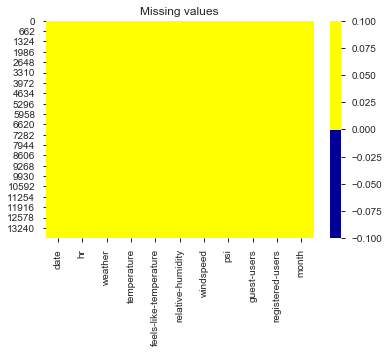

In [18]:
# Nice! No missing value at all (for future purposes if missing values involved)
mm.heatmap_missing(train)

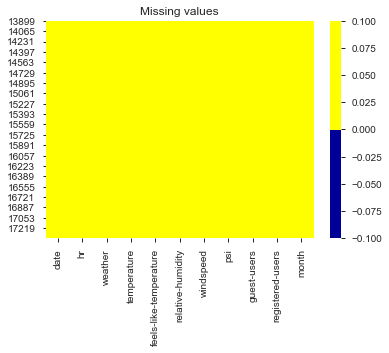

In [19]:
mm.heatmap_missing(test)

# 3. Target variable

> #### It is very important to first understand our target variable(s) before proceeding with further steps.
> #### Target variable: Total number of users
> #### Made up of 2 target variables:
> ###### 1) guest-users
> ###### 2) registered-users

## a. Plot visualization charts

>  ### View target variables in histogram, boxplot and qq plot

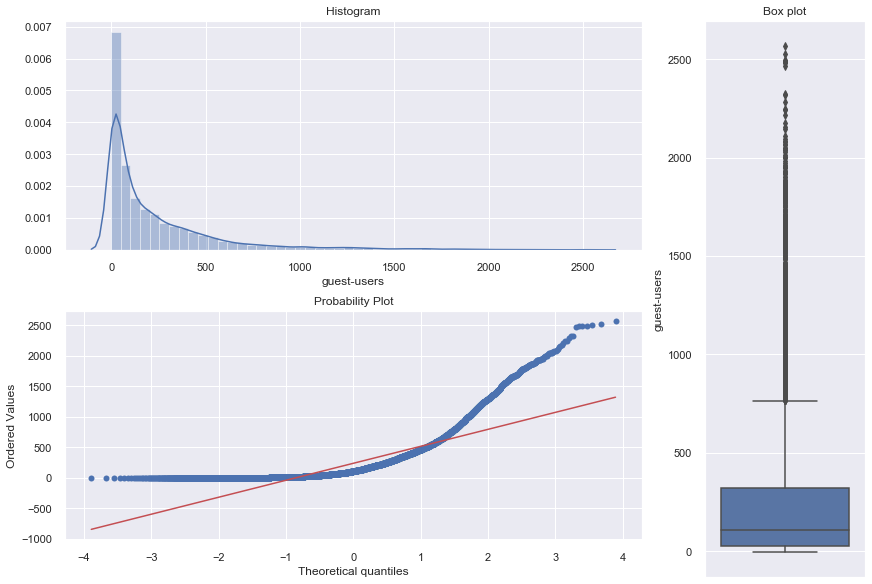

In [21]:
# Findings: abnormal distribution, right-skewed, outliers present
vm.plot_chart(train, 'guest-users')

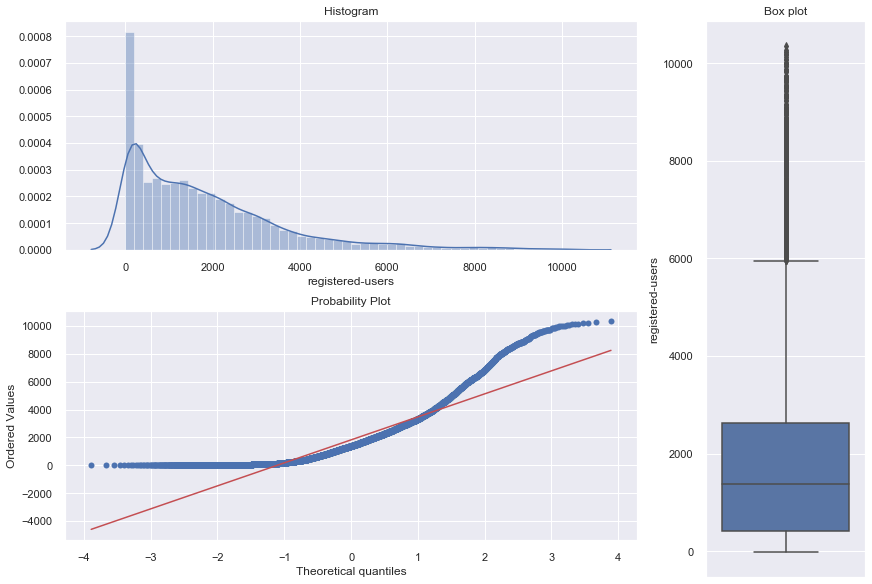

In [22]:
# Findings: abnormal distribution, right-skewed, lesser outliers present
vm.plot_chart(train, 'registered-users')

## b. Check for Skewness and Kurtosis

In [24]:
# Guest users values
print("Guest users:")
fm.skew_kurtosis_value(train, 'guest-users')

Guest users:
Skewness: 2.51
Positive/right skewness: mean and median > mode.

Kurtosis: 7.73
Leptokurtic: more outliers


In [25]:
# Registered users values
print("\nRegistered users:")
fm.skew_kurtosis_value(train, 'registered-users')


Registered users:
Skewness: 1.56
Positive/right skewness: mean and median > mode.

Kurtosis: 2.8
Platykurtic: less outliers


## c. Correlation of all features vs target variable

In [29]:
# Correlation of guest users vs all other features 
print("\nGuest users:")
guest_feat = (train.corr())["guest-users"].sort_values(ascending=False)[1:]
print(guest_feat)


Guest users:
registered-users          0.516625
temperature               0.468155
feels-like-temperature    0.462490
hr                        0.304078
month                     0.084028
windspeed                 0.081420
psi                       0.000867
relative-humidity        -0.332278
Name: guest-users, dtype: float64


In [30]:
# Correlation of registered users vs all other features 
print("\nRegistered users:")
reg_feat = (train.corr())["registered-users"].sort_values(ascending=False)[1:]
print(reg_feat)


Registered users:
guest-users               0.516625
hr                        0.381840
temperature               0.361821
feels-like-temperature    0.358477
windspeed                 0.095297
month                     0.073075
psi                      -0.007870
relative-humidity        -0.284775
Name: registered-users, dtype: float64


> #### From above information (visualizaton charts, skew/kurt values, correlation stats table):
> #### We can infer that guest and registered users are highly correlated. 
> #### We can safely proceed on to combining guest and registered users into total users feature.

### Target variable: total-users

In [31]:
# Feature engineer new feature (guest + registered)
train['total-users'] = train['guest-users'] + train['registered-users']
test['total-users'] = test['guest-users'] + test['registered-users']

In [32]:
print("Added new feature: total-users")
train.head()

Added new feature: total-users


date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  \
0               81.0        0.0    3           21               164      1   
1               80.0        0.0   35           54               417      1   
2               80.0        0.0   38           35               356      1   
3               75.0        0.0   35           19               129      1   
4               75.0        0.0   11           -2                10      1   

   total-users  
0          185  
1          471  
2          391  
3          148  
4            8

In [36]:
# Correlation of total-user vs other features
total_feat = (train.corr())["total-users"].sort_values(ascending=False)[1:]
print(total_feat)

registered-users          0.989664
guest-users               0.634072
temperature               0.405184
feels-like-temperature    0.401216
hr                        0.395782
windspeed                 0.099703
month                     0.080070
psi                      -0.006963
relative-humidity        -0.312844
Name: total-users, dtype: float64


In [34]:
# Total users values
print("\nTotal users:")
fm.skew_kurtosis_value(train, 'total-users')


Total users:
Skewness: 1.36
Positive/right skewness: mean and median > mode.

Kurtosis: 1.91
Platykurtic: less outliers


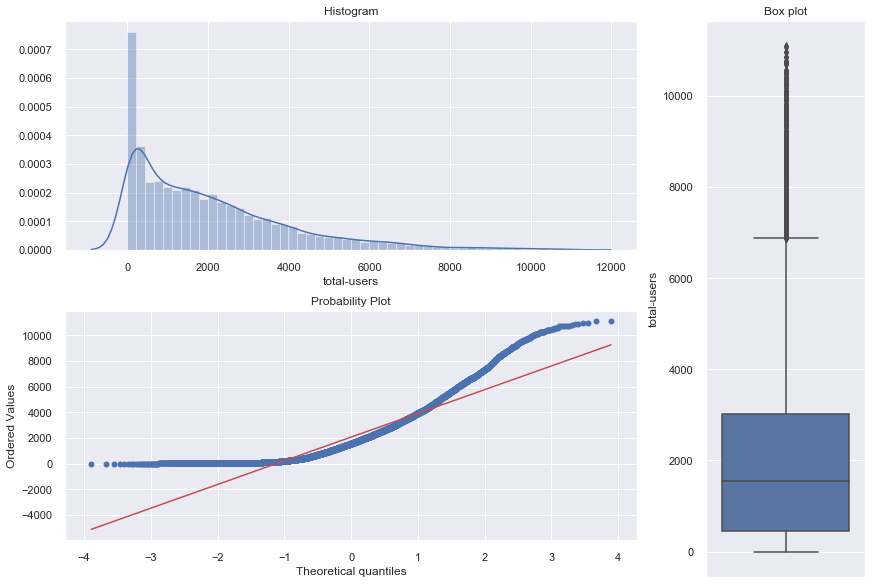

In [35]:
# Findings: abnormal distribution, right-skewed, lesser outliers present
vm.plot_chart(train, 'total-users')

# 4. Correlation charts

## a. Heatmap

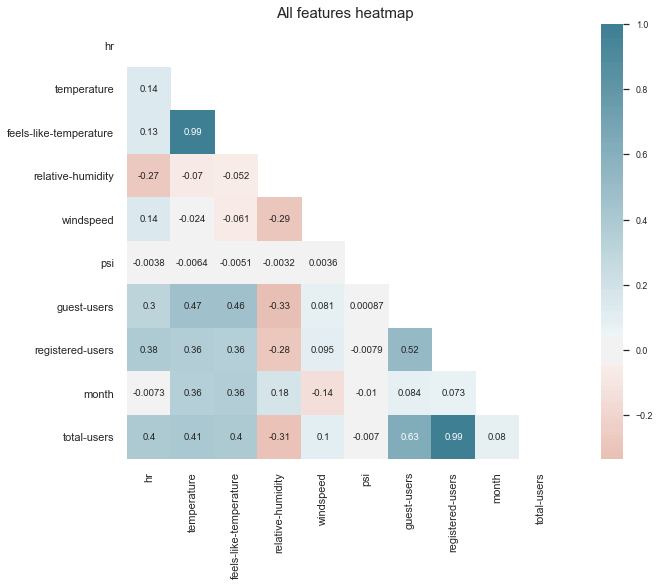

In [37]:
# Correlation matrix in heatmap
vm.heatmap_full(train)

### Observation
> #### From the heatmap, we can see that multicollinearity exists in some features. E.g. total users, guest and registered.
> #### We will use regularization models such as Ridge, Lasso,ElasticNet for cleaning up later.
* 40% correlation between total-users and hr, temperature, feels-like-temperature
* 64% correlation between total-users and guest users
* 99% corrrelation between total-users and registered users

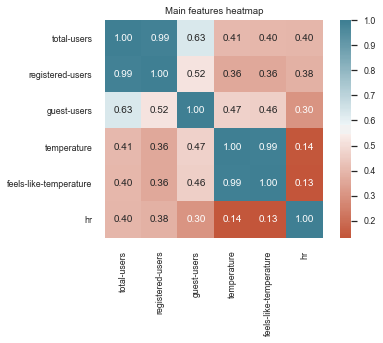

In [38]:
# Main features focused heatmap
vm.heatmap_focused(train, 'total-users', 6)

## b. Scatter plots

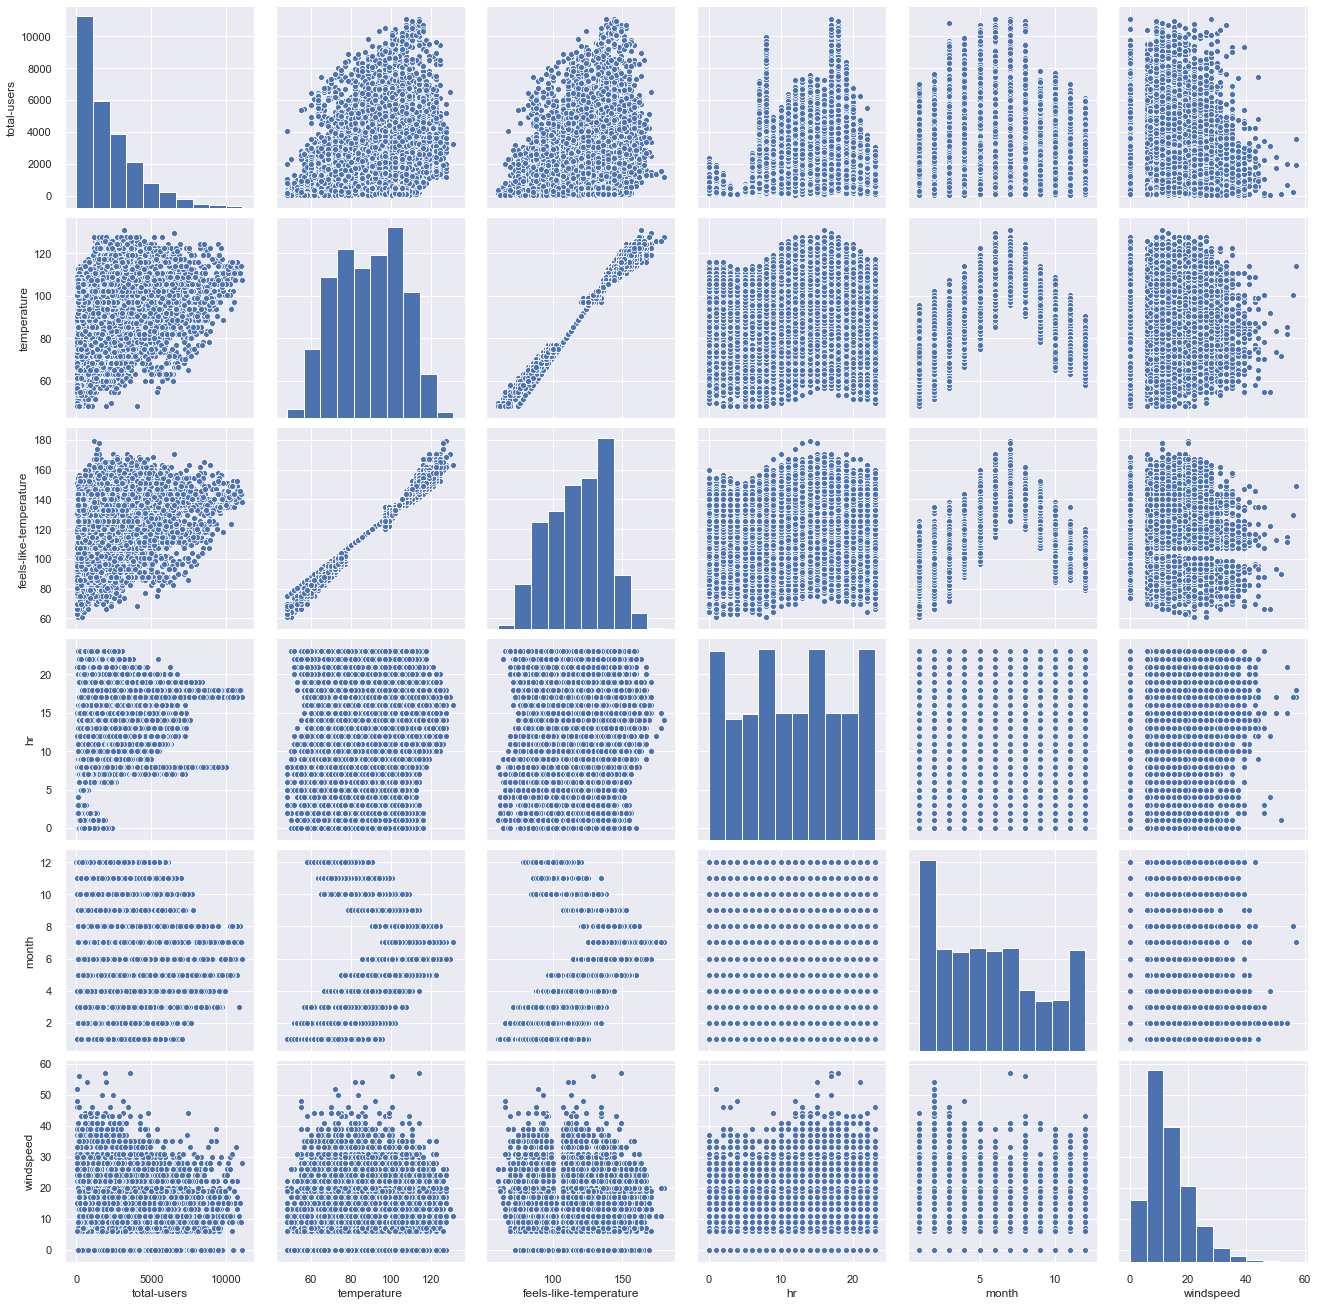

In [40]:
# Scatter plot (features to compare)
features = ['total-users', 'temperature', 'feels-like-temperature', 'hr', 'month', 'windspeed']
vm.scatter_plots(train, features)

> ### Based on the scatter plots above:
* we can see several features with linear relationship with the target variable
* the most popular hr and month periods
* Outliers not visibly present (features vs target plots)

# 5. Outliers

## a. Univariate analysis

* Establish a threshold to determine an outlier
* Done by standardize data: convert data values to their mean value = 0 and SD = 1

In [41]:
# Adjusted total user, increase array dimension by 1
total_users_adj = StandardScaler().fit_transform(train['total-users'][:, np.newaxis])
high_range = total_users_adj[total_users_adj[:, 0].argsort()][-10:]     # last 10 in range
low_range = total_users_adj[total_users_adj[:, 0].argsort()][:10]       # first 10 in range
print('Outer low range of the distribution:')
print(low_range)
print('\nOuter high range of the distribution:')
print(high_range)

Outer low range of the distribution:
[[-1.04338861]
 [-1.04237776]
 [-1.04237776]
 [-1.04187233]
 [-1.0413669 ]
 [-1.0413669 ]
 [-1.04086148]
 [-1.04086148]
 [-1.04035605]
 [-1.04035605]]

Outer high range of the distribution:
[[4.37781802]
 [4.37983973]
 [4.38590485]
 [4.39146454]
 [4.43543666]
 [4.44049093]
 [4.49153902]
 [4.49760414]
 [4.55421193]
 [4.56128791]]


> Findings:
> * Low range values close to 0
> * High range values far from 0
> * No outliers present

## b. Bivariate analysis
* Use scatter plot for numerical features to find outliers
* Use box plot for catergorical feature to find outliers

In [42]:
# Using statistics to check for outliers in temperature first
feature = 'temperature'
train[feature].describe()                
print("Max value of temperature: {}\n75th percentile value of weather: {}\nNo obvious outlier present".format(train[feature].max(), train[feature].quantile(0.75)))

Max value of temperature: 131.0
75th percentile value of weather: 102.2
No obvious outlier present


#### Scatter plot in-depth look

In [44]:
# Temperature vs total users
vm.bivariate_scatter(train, 'temperature', 'total-users')

In [45]:
# Feels-like-temperature vs total users
vm.bivariate_scatter(train, 'feels-like-temperature', 'total-users')

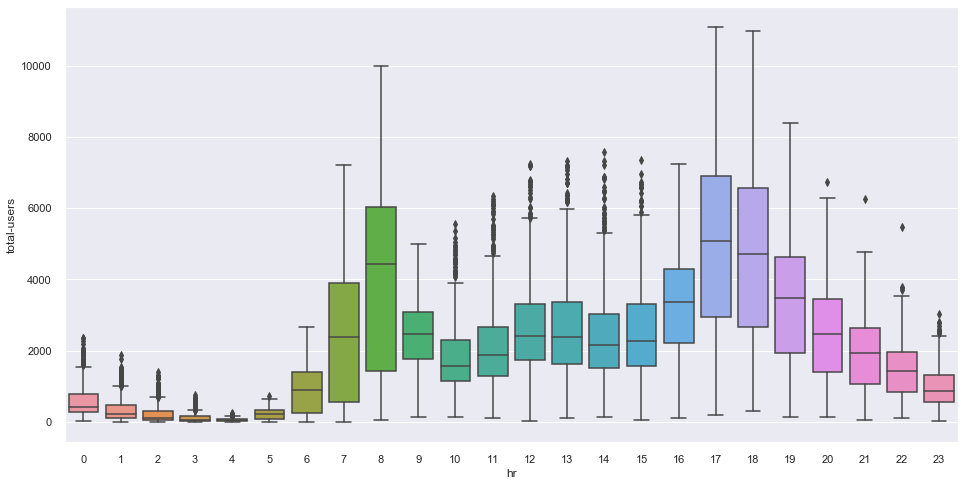

In [47]:
# Box plot hr vs total-users
vm.bivariate_boxplot(train, 'hr', 'total-users')

In [48]:
# Using plotly interactive boxplot to navigate each points, a clearer understanding of each hr class
fig = px.box(train, x='hr', y='total-users')
fig.show()

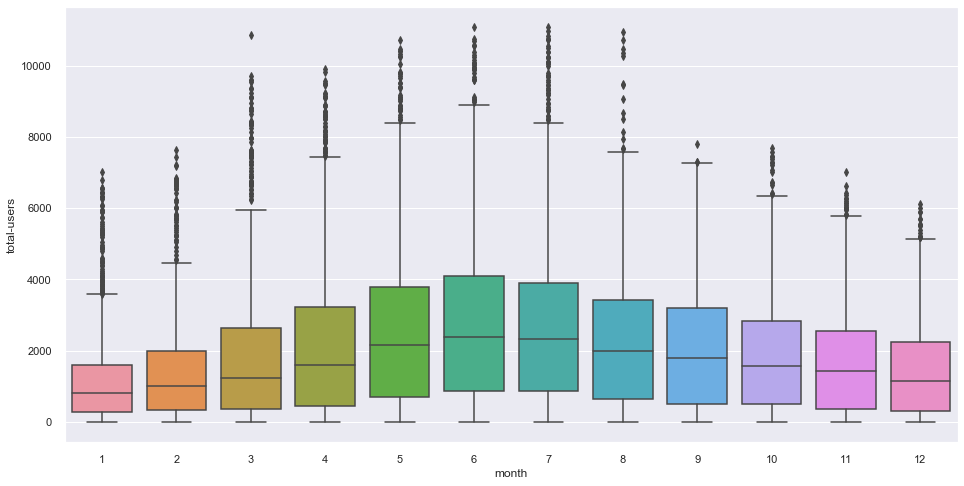

In [49]:
# Month vs total users
vm.bivariate_boxplot(train, 'month', 'total-users')

In [50]:
fig = px.box(train, x='month', y='total-users')
fig.show()

> ### Use box plot to visualize relationship among categorical feature

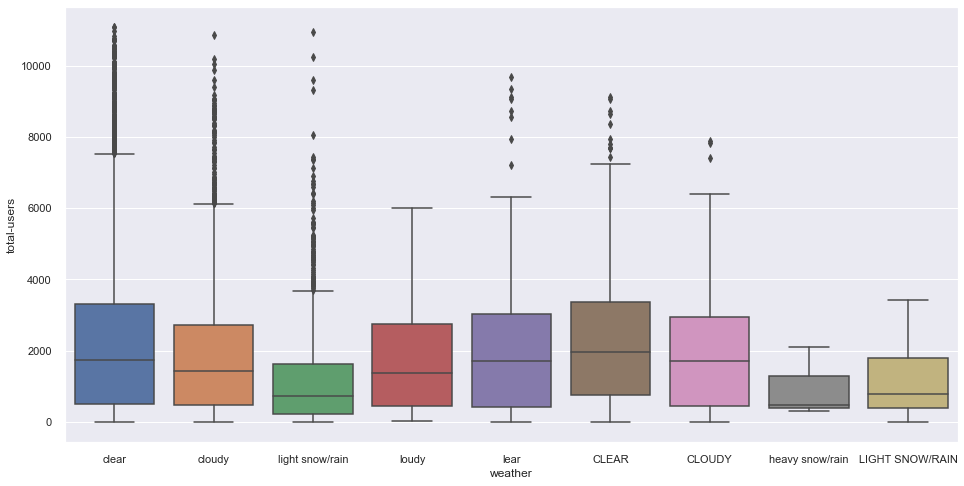

In [51]:
# Box plot weather vs total-users
vm.bivariate_boxplot(train, 'weather', 'total-users')

> #### Based on above charts, we can see several outliers and feature's classes that requires feature engineering. It has inconsistent catergorical values in the data.

#### 'month' feature:
* Several outliers are shown in the month feature's classes. However, they could be ignored as there will be some days in the month or day where there will be more total users (E.g. weekends, public holidays)
* Upwards trend from beginning of year to mid, where it continues with a downward trend to end of year. 

#### 'hr' feature:
* Some outliers found in hr feature's classes (late timings) can be ignored too since there may be some people who likes to enjoy the night breeze occansionally (which suggests the little amt of outliers).
* The noon timings consists of more outliers which may be the rise in food delivery services or those people going out for lunch etc. It need not to be removed as during model fitting, we will rely on certain techniques to prevent outliers from affecting our model.
* Boxplot figure shows higher number of users during morning and evening peak hour periods. This could be affected by the morning and evening peak hour commuters whom includes scooter as their transport method.

#### 'weather' feature:
* weather classes have inconsistent data as their catergorical names are filled with errors/typos/capitalization issues.
* E.g. Classes with spelling error: cloudy spelled as loudy or CLOUDY.
* It is hard to visualize the data without first solving the issue and group the observations accordingly and accurately.
* However, it is obvious that there are more users during clear or cloudy weather as compared to raining/snowy weather.
* As most days are clear or cloudy, it could not show the significant of the weather category as rain/snow can largely affect the number of users.


> #### We will do feature engineering later to get rid of all the inconsistency issue.

## c. Check for regression and fix target variable

In [52]:
# Make a train copy to compare before and after transformation chart
pre_train = train.copy()

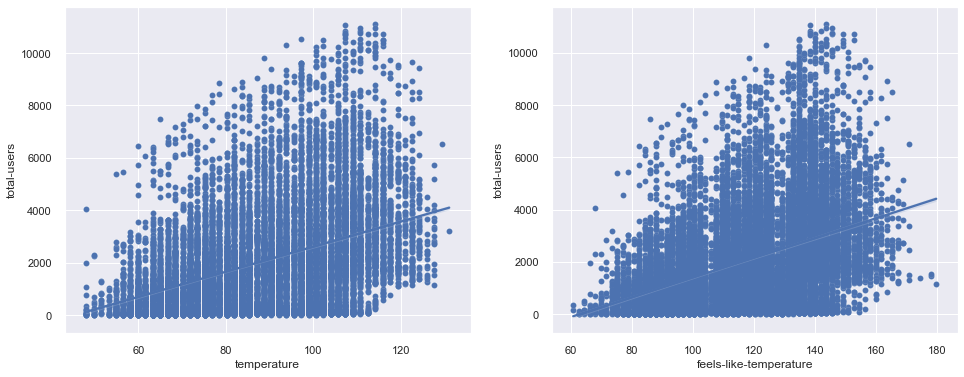

In [53]:
# Check for regression in features
vm.regression_check(train, 'total-users', 'temperature', 'feels-like-temperature')

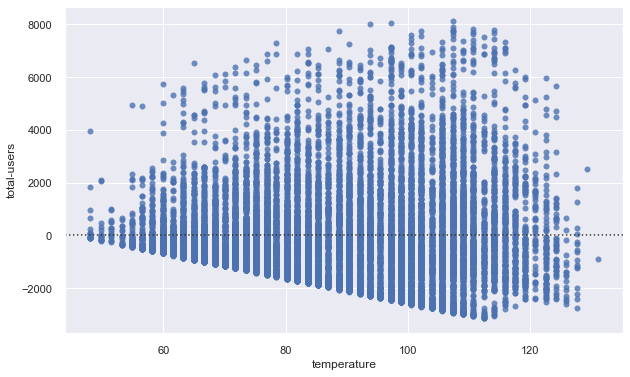

In [55]:
# Find error variance across true line
vm.error_variance(train, 'temperature', 'total-users')

> ### Transform target variable using log transformation

Before transformation


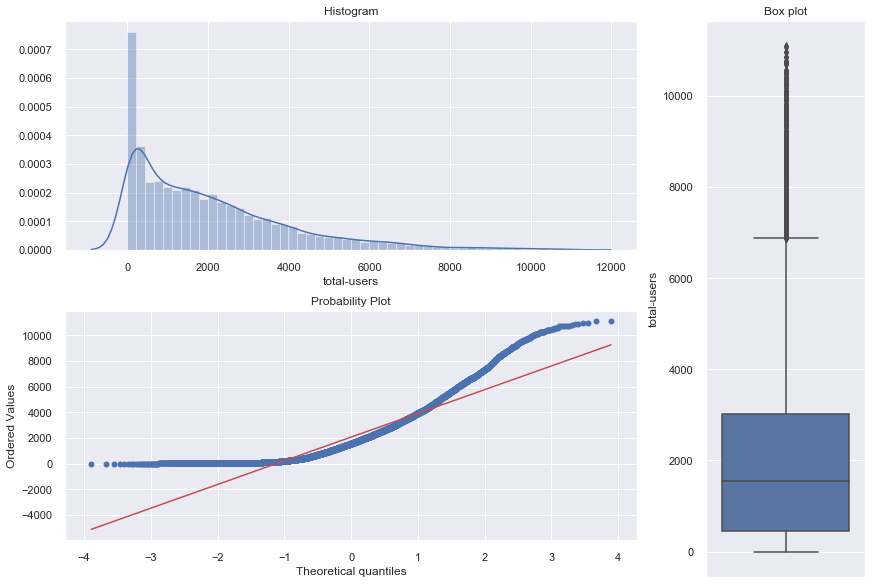

In [56]:
# Before transformation
print("Before transformation")
vm.plot_chart(train, 'total-users')

After transformation


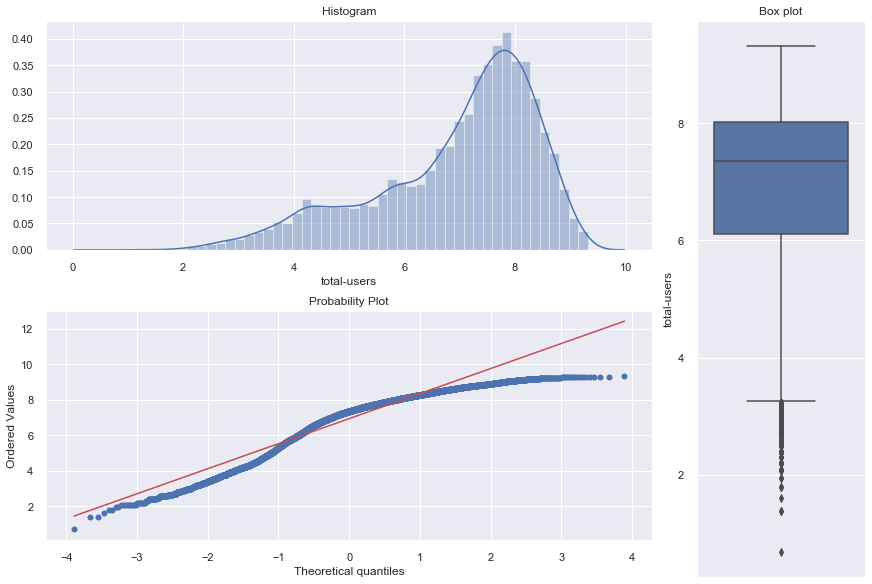

In [57]:
# Transform target variable using log transformation
train["total-users"] = np.log1p(train["total-users"])
print("After transformation")
# Plot newly transformed
vm.plot_chart(train, 'total-users')

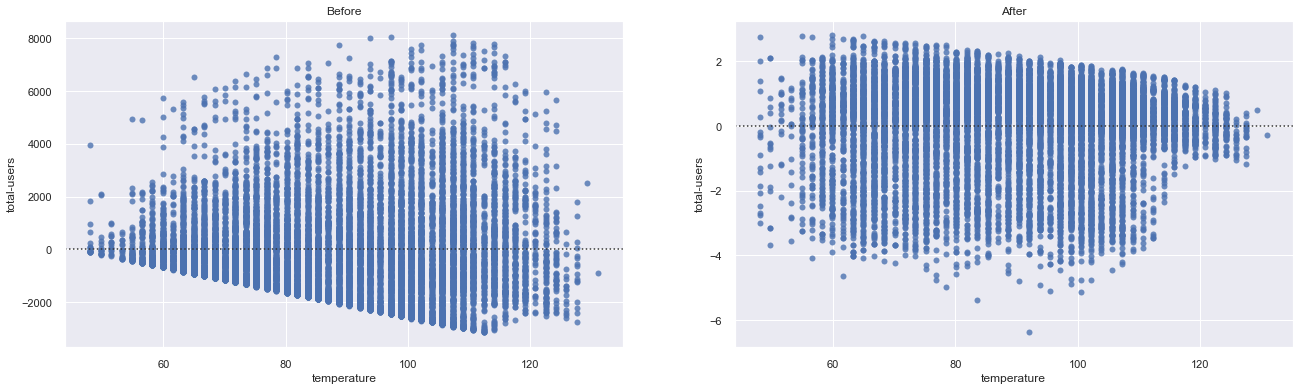

In [58]:
# Comparing before and after adjusted target vs feature
vm.compare_error_variance(pre_train, train, 'temperature', 'total-users')

# 6. Feature Engineering

## a. Repetitive values

In [59]:
# Saving the target variable for y train set 
y = train['total-users'].reset_index(drop=True)

# Saving the target variable for y test set
y_test = test['total-users'].reset_index(drop=True)

# Combine train and test datasets together
full_data = pd.concat((train, test)).reset_index(drop=True)
# Remove the target variable 
full_data.drop(['total-users'], axis=1, inplace=True)

In [60]:
# View and understand repetitive reason, drop if uninformative (Result: no repetitive values)
fm.repetitive(full_data)

## b. Duplicates

In [61]:
# Check for any duplicates left
fm.duplicate_drop(full_data)

(17379, 11)
(17379, 11)
Number of duplicates dropped: 
Rows: 0
Columns: 0


## c. Fix skewed features

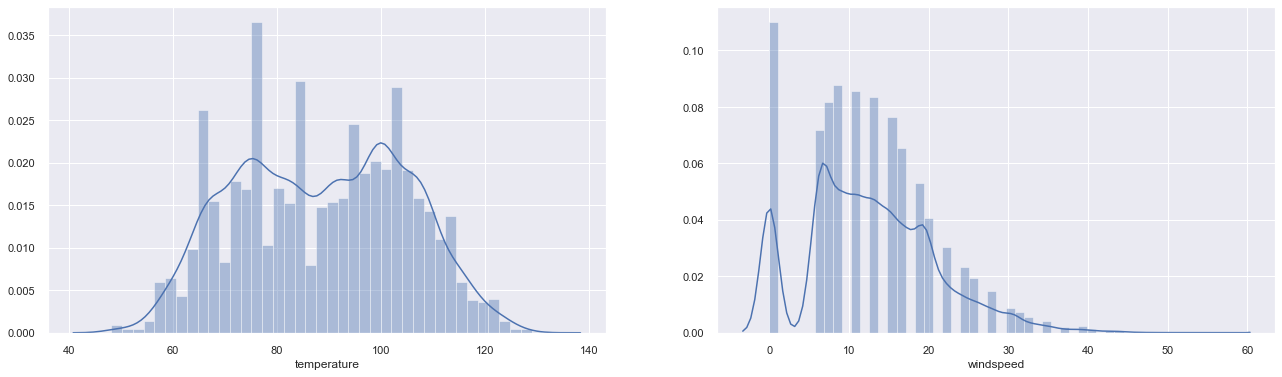

In [62]:
# Examples of skewed features
vm.skew_plot(full_data, 'temperature', 'windspeed')

In [63]:
# Very little features are skewed
fm.skewness_list(full_data)

guest-users               2.498891
registered-users          1.557765
windspeed                 0.574794
psi                      -0.001310
temperature              -0.006289
month                    -0.009252
hr                       -0.010679
feels-like-temperature   -0.090470
relative-humidity        -0.111278
dtype: float64

> ### Fix skewness using boxcox transformation

In [65]:
fm.fix_skewness(full_data)
print("Skewness fixed")

Skewness fixed


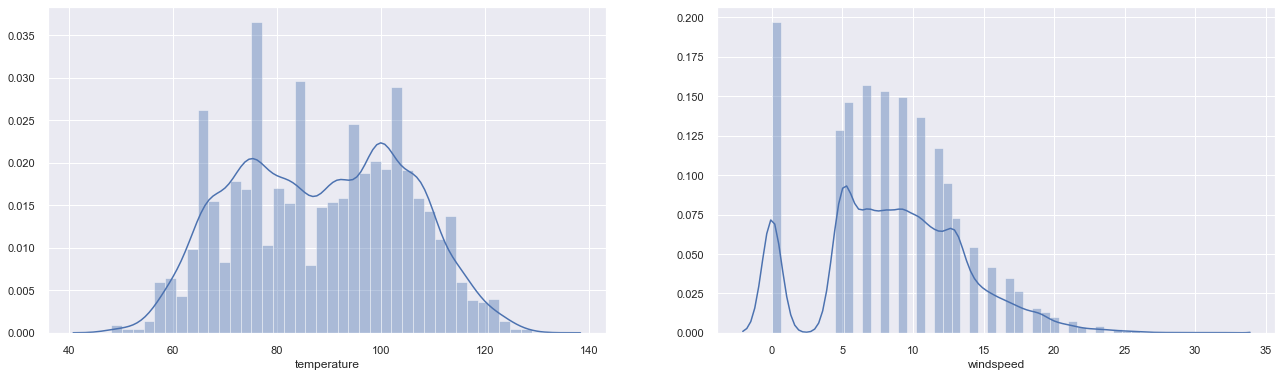

In [66]:
# Fixed skewed features
vm.skew_plot(full_data, 'temperature', 'windspeed')

## d. Fix inconsistent data

In [67]:
# Check for inconsistency in categorical feature
weather = fm.inconsistent_feature_check(full_data, 'weather')

clear              10830
cloudy              4343
light snow/rain     1390
lear                 311
CLEAR                272
loudy                107
CLOUDY                94
LIGHT SNOW/RAIN       29
heavy snow/rain        3
Name: weather, dtype: int64


> #### Categorical feature usually contains alot of inconsistent data:
* Capitalization
* Formats
* Categorical Values
* Addresses

> #### In this dataset, there's only 1 categorical feature: weather
> #### As shown above, it contains capitalization and categorical values error.
> #### The issues will be addressed in the following code sections

In [68]:
# Fix capitalization inconsistency
fm.capitalization_fix(full_data, 'weather')

In [69]:
# After adjusted to lower case
weather = fm.inconsistent_feature_check(full_data, 'weather')

clear              11102
cloudy              4437
light snow/rain     1419
lear                 311
loudy                107
heavy snow/rain        3
Name: weather, dtype: int64


In [70]:
# get the top 10 closest matches to "clear"
matches = fuzzywuzzy.process.extract("cloudy", weather, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches

[('cloudy', 100),
 ('loudy', 91),
 ('clear', 36),
 ('lear', 20),
 ('light snow/rain', 19),
 ('heavy snow/rain', 10)]

In [71]:
# Replace incorrect to specified correct class name
fm.replace_matches(full_data, 'weather', 'clear', 80)

REPLACED!


In [72]:
# Replace incorrect to specified correct class name
fm.replace_matches(full_data, 'weather', 'cloudy', 80)

REPLACED!


In [73]:
# Check for anymore inconsistency in categorical feature
fm.inconsistent_feature_check(full_data, 'weather')

clear              11413
cloudy              4544
light snow/rain     1419
heavy snow/rain        3
Name: weather, dtype: int64


array(['clear', 'cloudy', 'heavy snow/rain', 'light snow/rain'],
      dtype=object)

## e. Add dummies!

In [74]:
# Before that, we need to drop the date column since its not correlated to the target variable, month and hr are sufficient
full_data.drop(['date'], axis=1, inplace=True)
full_data.shape

(17379, 10)

In [75]:
# Create dummy variabes
full_data = pd.get_dummies(full_data).reset_index(drop=True)
full_data.shape

(17379, 13)

In [76]:
# Take as many rows as y dataset, all columns (train and validation set)
X = full_data.iloc[:len(y), :]
# Take the rest of the rows and all columns (submission test set)
X_test = full_data.iloc[len(y):, :]

In [77]:
print(full_data.shape, X.shape, y.shape, X_test.shape, y_test.shape)

(17379, 13) (13899, 13) (13899,) (3480, 13) (3480,)


> #### Check for overfitting features, remove if found

In [78]:
# Decide whether to drop overfitted features
overfits = fm.overfit_features(X)

print("List of overfitted features: \n{}".format(overfits))
X = X.drop(overfits, axis=1)
print("List of overfitted features: \n{}".format(overfits))
X_test = X_test.drop(overfits, axis=1)
print("Overfit features dropped.")

List of overfitted features: 
['weather_heavy snow/rain']
List of overfitted features: 
['weather_heavy snow/rain']
Overfit features dropped.


# 7. Algorithm Selection

## a. Split train set and define optimal threshold

In [80]:
# Split train data into train/test sets, k num of folds, shuffle data before split, set constant random generator 
# Assign diff alphas values to find best fit for model
# Algorithm class object (above all done in algorithm class)
a = am.Algorithms()

## b. Regularization and Regression Algorithms

In [81]:
# Regularization algorithms
a.regularization_models()

# Regression algorithms
a.regression_models()

## c. Score each algorithms

In [82]:
# Score of each model
score = a.rmseCV(X, y, a.ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = a.rmseCV(X, y, a.lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = a.rmseCV(X, y, a.elastic_net)
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = a.rmseCV(X, y, a.svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = a.rmseCV(X, y, a.lightgbm)
print("LightGBM: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = a.rmseCV(X, y, a.xgboost)
print("Xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

#score = a.rmseCV(X, y, a.stack_reg)
#print("Stack: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Ridge: 0.7685 (0.0212)
 2020-03-14 20:24:24.500097
LASSO: 0.7686 (0.0210)
 2020-03-14 20:24:27.954697
Elastic net: 0.7686 (0.0211)
 2020-03-14 20:24:37.833163
SVR: 0.3034 (0.0260)
 2020-03-14 20:37:35.337093
LightGBM: 0.1278 (0.0065)
 2020-03-14 20:37:54.551636
[20:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:07] WARNING: src/objective/regressi

# 8. Fit Model

In [87]:
# Fit model function from algorithm module class
a.fit_models(X, y)

Fitting Model...
Ridge
Lasso
ElasticNet
SVR
LightGBM
XGBoost
[20:51:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
StackRegressor
[20:56:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederr

## a. Blending models!!!
> #### Combine models for the best prediction
> #### Tunable parameters for best outcome
* Best prediction value comes from xgb and stack regressor.
* Percentage is tunable but should not be overadjusted towards certain models
* This prevents overfitting as this model could be tested with different datasets that contains more outliers
* Ridge is to ensure robustness in the model even though it predicted worse than others in this dataset

In [88]:
# Percentage of each models is tunable for best overall prediction value (algorithm class)
a.blend_models_predict(X)

array([5.2423737 , 6.01431266, 5.85316452, ..., 6.03460182, 7.57466541,
       8.77187774])

### Root mean squared log error(RMSLE) chosen to scale down outliers, nullify their effects
* only consider relative error:
* relative error = absolute error(magnitude of error) / exact value (magnitude)
* E.g:
* y=100, X_pred=90 => RMSLE (cal relative error)=10/100 = 0.1
* y=10000, X_pred=9000 => RMSLE=1000/10000 = 0.1
* biased penalty:
* larger penalty for underestimation of value than overestimation
* E.g:
* y=1000, X_pred=600 => RMSLE = 0.51 (underestimation)
* y=1000, X_pred=1400 => RMSLE = 0.33 (overestimation)
* Overestimated sale price: if sell more to earn, if buy more money prepared
* Useful for delivery time regression problem

In [89]:
# X train prediction
y_pred = a.blend_models_predict(X)
print("Predicted values (log transformed): ")
print(list(y_pred)[:10])

print("\nExponential transform predicted values..\n")
# expm1 to reverse the logp1 values of predicted y values, floor to round into actual values
y_pred = np.floor(np.expm1(y_pred))
print("Normal predicted values: ")
print(list(y_pred)[:10])

# Compare to actual train set y value (total users)
print("\nActual values for comparison: ")
print(list(np.floor(np.expm1(y)))[:10])

Predicted values (log transformed): 
[5.242373695213554, 6.014312661452161, 5.85316451893735, 5.04026124428405, 2.8186982776232927, 3.1034703938267914, 3.346643676909366, 3.880840338956725, 4.820950828109785, 4.956641775840616]

Exponential transform predicted values..

Normal predicted values: 
[188.0, 408.0, 347.0, 153.0, 15.0, 21.0, 27.0, 47.0, 123.0, 141.0]

Actual values for comparison: 
[185.0, 470.0, 390.0, 148.0, 8.0, 12.0, 16.0, 32.0, 103.0, 129.0]


> #### Pretty close based on the first 10 observations! However we would not want it to be too accurate as it may be due to overfitting which can lead to inaccurate predicton in the test set.
> #### Lets look at the accuracy score based on 2 performance metrics

## b. Accuracy score

### Train set

In [90]:
# Training set accuracy score, lower RMSLE better accuracy
print('RMSLE score on train data:')
print(a.rmsle(y, a.blend_models_predict(X)))

RMSLE score on train data:
0.024796783964187916


In [91]:
# Training set accuracy score, lower RMSE better accuracy
print('RMSE score on train data:')
print(a.rmse(y, a.blend_models_predict(X)))

RMSE score on train data:
0.12907648230067


### Test set

> #### Comparing accuracy score in different models to determine the best model to deploy

In [92]:
# Test set accuracy score, lower RMSLE better accuracy
print("RMSLE Accuracy Score for each model: \n")

print("Blended models:", a.rmsle(y_test, np.floor(np.expm1(a.blend_models_predict(X_test)))))
print("Stack Regressor:", a.rmsle(y_test, np.floor(np.expm1(a.stack_reg_models.predict(np.array(X_test))))))
print("XGB:", a.rmsle(y_test, np.floor(np.expm1(a.xgb_model.predict(X_test)))))
print("LGB:", a.rmsle(y_test, np.floor(np.expm1(a.lgb_model.predict(X_test)))))
print("SVR:", a.rmsle(y_test, np.floor(np.expm1(a.svr_model.predict(X_test)))))
print("Ridge:", a.rmsle(y_test, np.floor(np.expm1(a.ridge_model.predict(X_test)))))
print("ElasticNet", a.rmsle(y_test, np.floor(np.expm1(a.elastic_model.predict(X_test)))))
print("Lasso", a.rmsle(y_test, np.floor(np.expm1(a.lasso_model.predict(X_test)))))

RMSLE Accuracy Score for each model: 

Blended models: 0.1226357075084647
Stack Regressor: 0.02128001991140483
XGB: 0.027655831125407322
LGB: 0.14012172356020858
SVR: 0.2283939763266323
Ridge: 0.7807957582227769
ElasticNet 0.7817035705360633
Lasso 0.7818375961525957


In [93]:
# Test set accuracy score, lower RMSE better accuracy
print("RMSE Accuracy Score for each model: \n")

print("Blended models:", a.rmse(y_test, np.floor(np.expm1(a.blend_models_predict(X_test)))))
print("Stack Regressor:", a.rmse(y_test, np.floor(np.expm1(a.stack_reg_models.predict(np.array(X_test))))))
print("XGB:", a.rmse(y_test, np.floor(np.expm1(a.xgb_model.predict(X_test)))))
print("LGB:", a.rmse(y_test, np.floor(np.expm1(a.lgb_model.predict(X_test)))))
print("SVR:", a.rmse(y_test, np.floor(np.expm1(a.svr_model.predict(X_test)))))
print("Ridge:", a.rmse(y_test, np.floor(np.expm1(a.ridge_model.predict(X_test)))))
print("ElasticNet", a.rmse(y_test, np.floor(np.expm1(a.elastic_model.predict(X_test)))))
print("Lasso", a.rmse(y_test, np.floor(np.expm1(a.lasso_model.predict(X_test)))))

RMSE Accuracy Score for each model: 

Blended models: 728.4221885487254
Stack Regressor: 97.9109142355273
XGB: 134.13636375144426
LGB: 565.1663619383824
SVR: 484.7373192546257
Ridge: 17094.348120486135
ElasticNet 17200.40989662947
Lasso 17204.302252149995


> #### Seems like the test results have a close or lower RMSLE/RMSE scores which shows that we did not overfit our model! 
> #### Nice, lets submit our prediction! 

## Finally, submission!

> #### Model selection based on:
* performance score
* various performance metrics
* types of models fits certain problem
* validation score
* final results! 

#### Of course, considerations for different dataset or business problems will be factored in the selection.

In [94]:
# Create new submission file for prediction values
print('Submit prediction')
# Model selection
selected_model = a.stack_reg_models.predict(np.array(X_test)) 
pred_test = np.floor(np.expm1(selected_model))
#pred_test = blend_models_predict(X_test)
submission = pd.DataFrame({'Id': X_test.index, 'total-users': pred_test})
submission.to_csv('submission.csv', index=False)

Submit prediction


### Glimpse of submitted results vs actual results

In [95]:
print("Submitted results: ")
print(list(pred_test)[:10])
print("Actual values for comparison: ")
print(list(y_test)[:10])

Submitted results: 
[9006.0, 4004.0, 2674.0, 2241.0, 3207.0, 2916.0, 2954.0, 3365.0, 5224.0, 10564.0]
Actual values for comparison: 
[8918, 3988, 2714, 2275, 3163, 2884, 2935, 3385, 5186, 10534]
